# Creating Cohorts of Songs – Course-end Project 2
**Simplilearn AI & ML PGP | Spotify Rolling Stones Dataset**

**Objective:** Perform exploratory data analysis and cluster analysis to create cohorts of songs and understand the factors that define each cohort for better song recommendations.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')
print("Libraries loaded successfully.")

Libraries loaded successfully.


## 1. Load Data & Data Dictionary
Load the Rolling Stones Spotify dataset and (optionally) the data dictionary for column definitions.

In [3]:
# Load dataset
df = pd.read_csv('rolling_stones_spotify.csv')
# Remove unnamed index column if present
if df.columns[0].startswith('Unnamed') or df.columns[0] == '':
    df = df.iloc[:, 1:]
print("Dataset shape:", df.shape)
print("\nColumns:", list(df.columns))
df.head()

Dataset shape: (1610, 17)

Columns: ['name', 'album', 'release_date', 'track_number', 'id', 'uri', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity', 'duration_ms']


,name,album,release_date,track_number,id,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
0,Concert Intro Music - Live,Licked Live In NYC,2022-06-10,1,2IEkywLJ4ykbhi1yRQvmsT,spotify:track:2IEkywLJ4ykbhi1yRQvmsT,0.0824,0.463,0.993,0.996000,0.932,-12.913,0.1100,118.001,0.0302,33,48640
1,Street Fighting Man - Live,Licked Live In NYC,2022-06-10,2,6GVgVJBKkGJoRfarYRvGTU,spotify:track:6GVgVJBKkGJoRfarYRvGTU,0.4370,0.326,0.965,0.233000,0.961,-4.803,0.0759,131.455,0.3180,34,253173
2,Start Me Up - Live,Licked Live In NYC,2022-06-10,3,1Lu761pZ0dBTGpzxaQoZNW,spotify:track:1Lu761pZ0dBTGpzxaQoZNW,0.4160,0.386,0.969,0.400000,0.956,-4.936,0.1150,130.066,0.3130,34,263160
3,If You Can't Rock Me - Live,Licked Live In NYC,2022-06-10,4,1agTQzOTUnGNggyckEqiDH,spotify:track:1agTQzOTUnGNggyckEqiDH,0.5670,0.369,0.985,0.000107,0.895,-5.535,0.1930,132.994,0.1470,32,305880
4,Don’t Stop - Live,Licked Live In NYC,2022-06-10,5,7piGJR8YndQBQWVXv6KtQw,spotify:track:7piGJR8YndQBQWVXv6KtQw,0.4000,0.303,0.969,0.055900,0.966,-5.098,0.0930,130.533,0.2060,32,305106


In [6]:
# Load and display Data Dictionary (column definitions)
try:
    data_dict = pd.read_excel('Data Dictionary - Creating cohorts of songs.xlsx')
    print("Data Dictionary - Creating cohorts of songs:")
    display(data_dict)
except Exception as e:
    print("Data dictionary not loaded:", e)
    print("Spotify audio features: acousticness, danceability, energy, instrumentalness,")
    print("liveness, loudness, speechiness, tempo, valence, popularity, duration_ms")

Data dictionary not loaded: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.
Spotify audio features: acousticness, danceability, energy, instrumentalness,
liveness, loudness, speechiness, tempo, valence, popularity, duration_ms


## 2. Data Quality Checks
Check for missing values and basic statistics of numeric features used for clustering.

In [9]:
# Data quality - missing values
print("Missing values per column:")
print(df.isnull().sum())
print("\nTotal missing:", df.isnull().sum().sum())
print("\nData types:\n", df.dtypes)
# Numeric features (Spotify audio features) for clustering
feature_cols = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness',
               'loudness', 'speechiness', 'tempo', 'valence', 'popularity', 'duration_ms']
df_numeric = df[feature_cols].copy()
print("\nBasic statistics of clustering features:")
df_numeric.describe()

Missing values per column:
name                0
album               0
release_date        0
track_number        0
id                  0
uri                 0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
popularity          0
duration_ms         0
dtype: int64

Total missing: 0

Data types:
 name                 object
album                object
release_date         object
track_number          int64
id                   object
uri                  object
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity            int64
duration_ms           int64
dtype: object

Basic statistics of clustering features:


,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
count,1610.000000,1610.000000,1610.000000,1610.000000,1610.00000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000
mean,0.250475,0.468860,0.792352,0.164170,0.49173,-6.971615,0.069512,126.082033,0.582165,20.788199,257736.488199
std,0.227397,0.141775,0.179886,0.276249,0.34910,2.994003,0.051631,29.233483,0.231253,12.426859,108333.474920
min,0.000009,0.104000,0.141000,0.000000,0.02190,-24.408000,0.023200,46.525000,0.000000,0.000000,21000.000000
25%,0.058350,0.362250,0.674000,0.000219,0.15300,-8.982500,0.036500,107.390750,0.404250,13.000000,190613.000000
50%,0.183000,0.458000,0.848500,0.013750,0.37950,-6.523000,0.051200,124.404500,0.583000,20.000000,243093.000000
75%,0.403750,0.578000,0.945000,0.179000,0.89375,-4.608750,0.086600,142.355750,0.778000,27.000000,295319.750000
max,0.994000,0.887000,0.999000,0.996000,0.99800,-1.014000,0.624000,216.304000,0.974000,80.000000,981866.000000


## 3. Exploratory Data Analysis
Understand distributions and relationships among audio features that will define song cohorts.

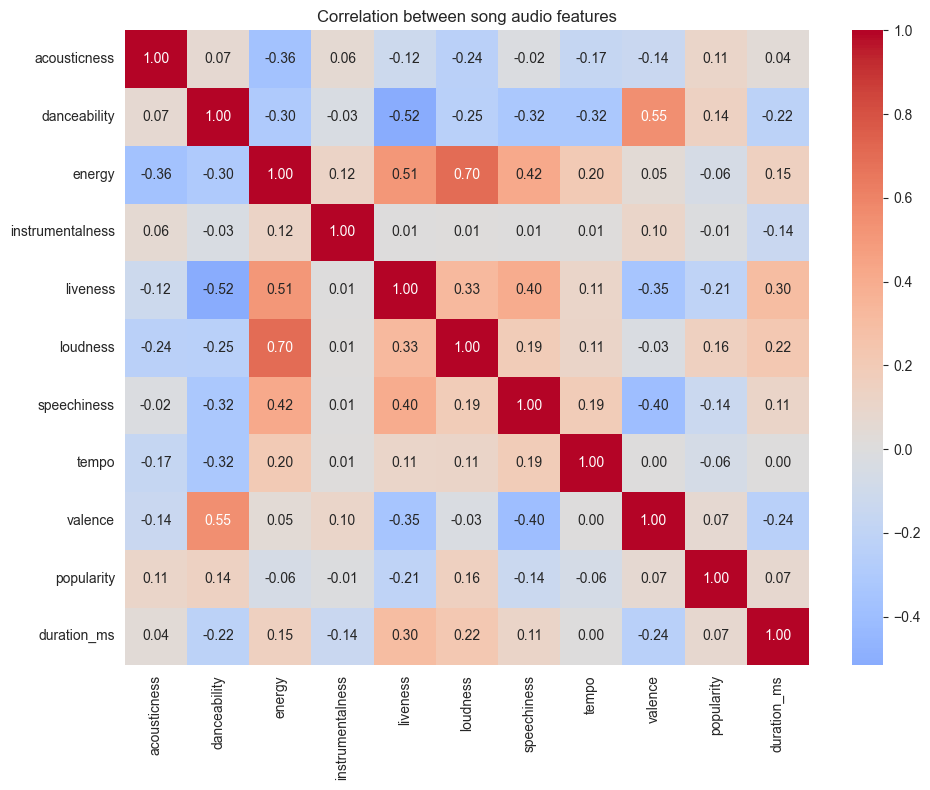

In [12]:
# Correlation heatmap of numeric features
plt.figure(figsize=(10, 8))
corr = df_numeric.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation between song audio features')
plt.tight_layout()
plt.show()

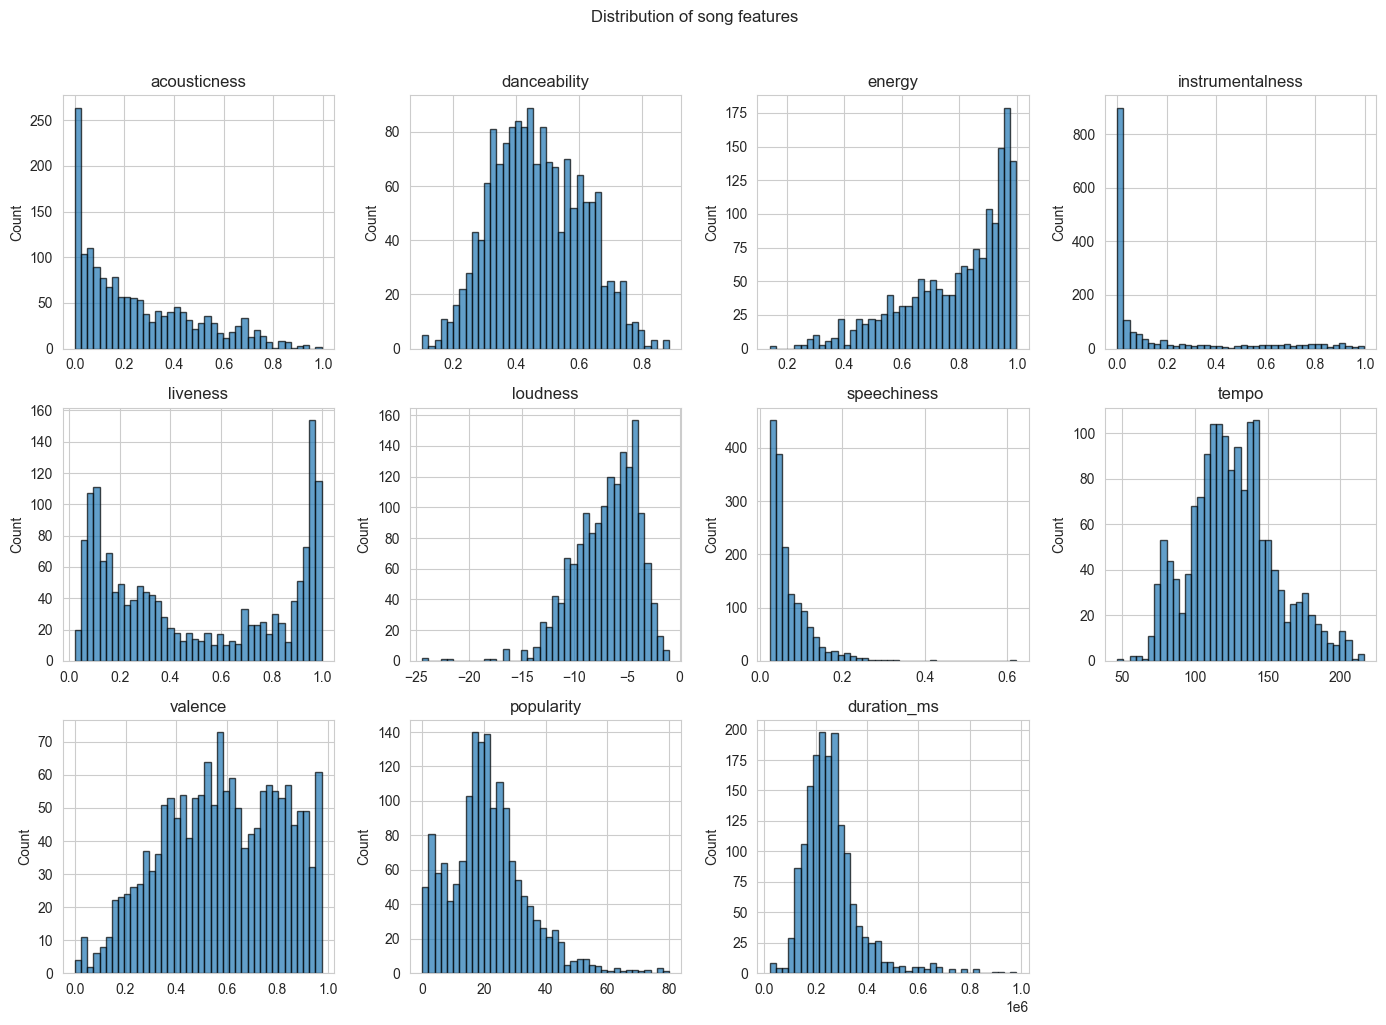

In [14]:
# Distributions of key features
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
axes = axes.flatten()
for i, col in enumerate(feature_cols):
    axes[i].hist(df_numeric[col].dropna(), bins=40, edgecolor='black', alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_ylabel('Count')
axes[-1].axis('off')
plt.suptitle('Distribution of song features', y=1.02)
plt.tight_layout()
plt.show()

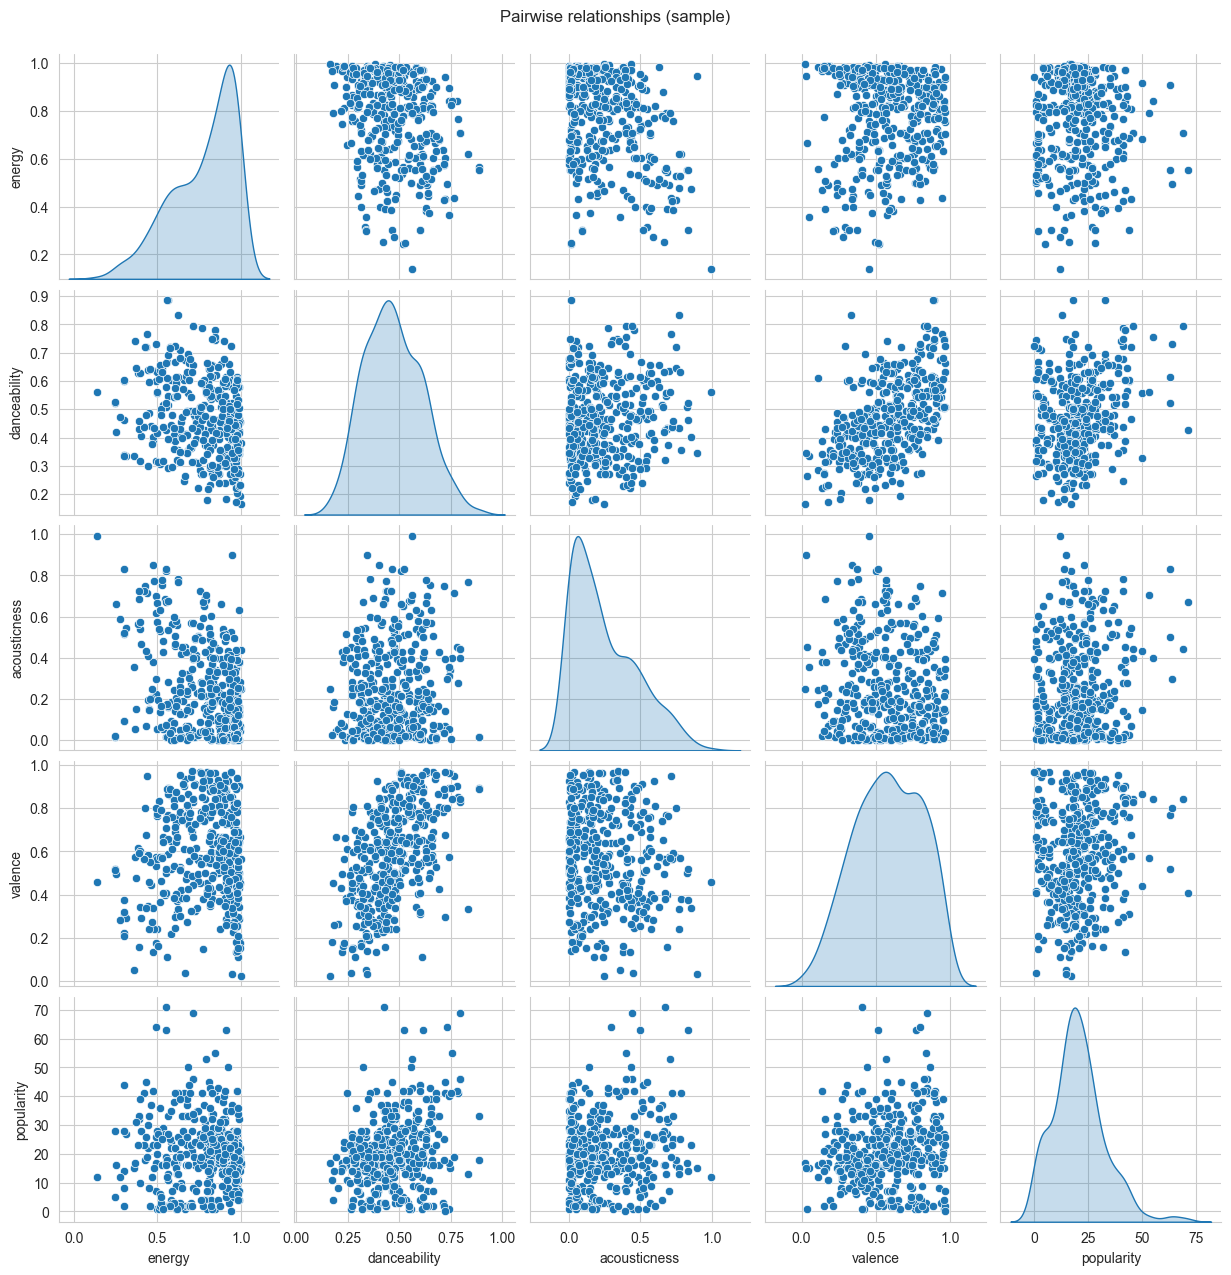

In [16]:
# Pairplot of a subset of features (sample for speed)
sample = df_numeric.sample(min(400, len(df_numeric)), random_state=42)
sns.pairplot(sample[['energy', 'danceability', 'acousticness', 'valence', 'popularity']], diag_kind='kde')
plt.suptitle('Pairwise relationships (sample)', y=1.02)
plt.show()

## 4. Cluster Analysis – Creating Cohorts of Songs
Scale features and apply K-Means. Use elbow method and silhouette score to choose number of cohorts (k).

In [19]:
# Handle any missing values and scale features
X = df_numeric.dropna()
if len(X) < len(df_numeric):
    print("Dropped rows with missing values:", len(df_numeric) - len(X))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled feature matrix shape:", X_scaled.shape)

Scaled feature matrix shape: (1610, 11)


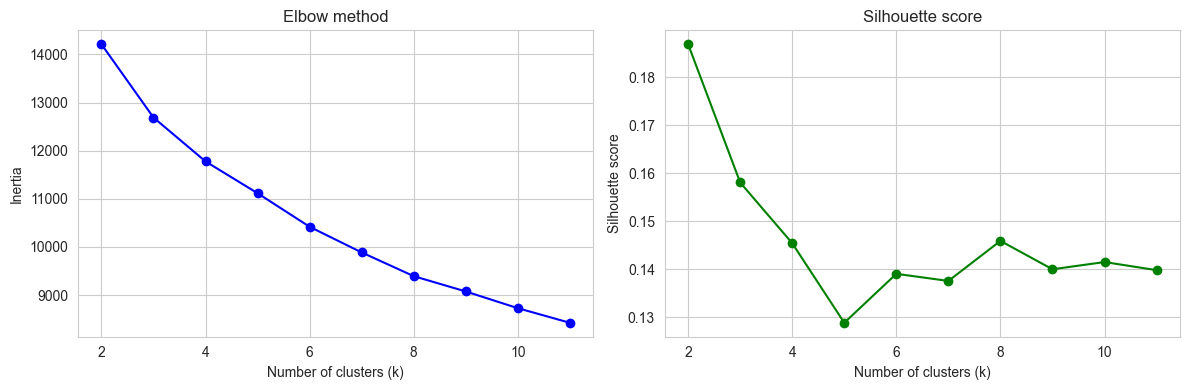

Silhouette scores: {2: 0.187, 3: 0.158, 4: 0.145, 5: 0.129, 6: 0.139, 7: 0.138, 8: 0.146, 9: 0.14, 10: 0.141, 11: 0.14}


In [37]:
# Elbow method and silhouette score for optimal k
inertias = []
silhouettes = []
K_range = range(2, 12)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow method')
axes[1].plot(K_range, silhouettes, 'go-')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Silhouette score')
axes[1].set_title('Silhouette score')
plt.tight_layout()
plt.show()
print("Silhouette scores:", dict(zip(K_range, [round(s, 3) for s in silhouettes])))

In [23]:
# Fit final K-Means with chosen k (e.g. k=5 for interpretable cohorts; adjust based on elbow/silhouette)
n_clusters = 5
kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)
# Attach cluster to dataframe for interpretation
df_clustered = X.copy()
df_clustered['cohort'] = cluster_labels
print("Cohort (cluster) sizes:")
print(df_clustered['cohort'].value_counts().sort_index())
print("\nSilhouette score for k=%d:" % n_clusters, round(silhouette_score(X_scaled, cluster_labels), 3))

Cohort (cluster) sizes:
cohort
0    381
1    253
2    252
3    369
4    355
Name: count, dtype: int64

Silhouette score for k=5: 0.129


## 5. Cohort Profiles – Factors That Define Each Cohort
Compare mean feature values across cohorts to interpret what type of songs each cohort represents.

In [26]:
# Cohort profiles (mean of each feature per cohort)
cohort_profiles = df_clustered.groupby('cohort')[feature_cols].mean()
cohort_profiles.round(3)

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
cohort,,,,,,,,,,,
0,0.193,0.402,0.887,0.057,0.851,-5.683,0.074,122.365,0.511,17.005,338533.780
1,0.521,0.464,0.545,0.081,0.274,-9.339,0.046,113.292,0.389,25.953,272789.585
2,0.198,0.315,0.944,0.280,0.799,-5.476,0.144,151.019,0.373,17.381,248718.056
3,0.199,0.531,0.878,0.239,0.316,-4.908,0.052,124.561,0.761,28.951,241231.341
4,0.210,0.589,0.670,0.179,0.225,-9.873,0.048,123.066,0.758,15.101,183851.538


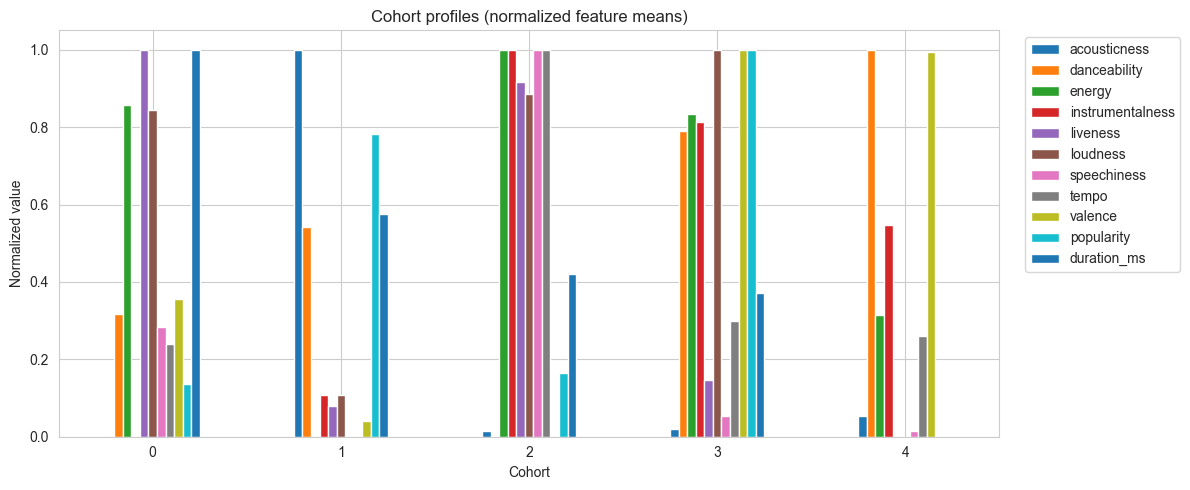

In [28]:
# Visualize cohort profiles (radar/bar)
cohort_profiles_plot = cohort_profiles.copy()
# Normalize for comparison (0-1 scale per feature for display)
for c in cohort_profiles_plot.columns:
    min_v, max_v = cohort_profiles_plot[c].min(), cohort_profiles_plot[c].max()
    if max_v > min_v:
        cohort_profiles_plot[c] = (cohort_profiles_plot[c] - min_v) / (max_v - min_v)
cohort_profiles_plot.plot(kind='bar', figsize=(12, 5))
plt.title('Cohort profiles (normalized feature means)')
plt.xlabel('Cohort')
plt.ylabel('Normalized value')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

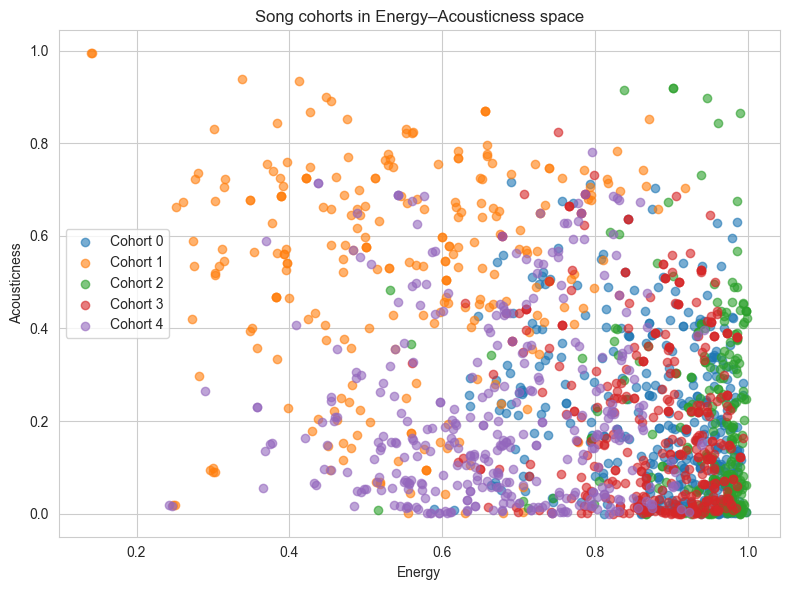

In [30]:
# 2D visualization: project cohorts by two important features (e.g. energy vs acousticness)
df_clustered['cohort'] = cluster_labels
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    subset = df_clustered[df_clustered['cohort'] == i]
    plt.scatter(subset['energy'], subset['acousticness'], label=f'Cohort {i}', alpha=0.6)
plt.xlabel('Energy')
plt.ylabel('Acousticness')
plt.title('Song cohorts in Energy–Acousticness space')
plt.legend()
plt.tight_layout()
plt.show()

## 6. Summary – Factors That Create Cohorts of Songs
Based on EDA and cluster analysis:

In [33]:
# Summary: key differentiators per cohort (top 3 features above/below overall mean)
overall_mean = df_clustered[feature_cols].mean()
print("Factors that create distinct song cohorts (vs overall mean):\n")
for cohort_id in range(n_clusters):
    cohort_mean = cohort_profiles.loc[cohort_id]
    diff = (cohort_mean - overall_mean).reindex(cohort_mean.index)
    diff = diff.reindex(diff.abs().sort_values(ascending=False).index)
    top = diff.head(3)
    print("Cohort %d: " % cohort_id, " | ".join(["%s=%.2f" % (k, v) for k, v in top.items()]))
print("\nInterpretation: Cohorts are driven by energy, acousticness, danceability, valence,")
print("instrumentalness, tempo, and popularity. Use these profiles to recommend similar songs within each cohort.")

Factors that create distinct song cohorts (vs overall mean):

Cohort 0:  duration_ms=80797.29 | popularity=-3.78 | tempo=-3.72
Cohort 1:  duration_ms=15053.10 | tempo=-12.79 | popularity=5.16
Cohort 2:  duration_ms=-9018.43 | tempo=24.94 | popularity=-3.41
Cohort 3:  duration_ms=-16505.15 | popularity=8.16 | loudness=2.06
Cohort 4:  duration_ms=-73884.95 | popularity=-5.69 | tempo=-3.02

Interpretation: Cohorts are driven by energy, acousticness, danceability, valence,
instrumentalness, tempo, and popularity. Use these profiles to recommend similar songs within each cohort.
